In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import tqdm
import os
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png', 'pdf')

plt.style.use("../config/custom_plots.mplstyle")

In [2]:
def load_df(prefix, fracPos, beta, folder, p, qvotersteps, nagents=10000, nsteps=100, nruns=10):
    dfs = []
    for n in range(nruns):
        path = f"../simulations/{folder}/{prefix}_NAGENTS={nagents}_NSTEPS={nsteps}_NETWORKP=0.8_FRAC_LINKS=0.01_FRAC_POS_OPINION={fracPos}_FRAC_INFECTED=0.1_QVOTER=p={p}_q=6_PIS=0.0_EPIDEMIC=beta={beta}_zeta=0,00_alpha=0,00_gamma=0,50_mu=0,90_kappa=0,10_QVOTERSTEPS={qvotersteps}_NRUN={n}.tsv"
        
        df = pd.read_csv(path, sep="\t")
        dfs.append(df)
    dfs1 = pd.DataFrame(np.array([x.to_numpy() for x in dfs]).mean(axis=0),
                        index=df.index, 
                        columns=df.columns)
    columns = [f'{s}Std' for s in df.columns]
    dfs1Std = pd.DataFrame(np.array([x.to_numpy() for x in dfs]).std(axis=0),
                        index=df.index, 
                        columns=columns)
    dfs1Std['step'] = dfs1['step']
    dfs1 = dfs1.merge(dfs1Std, on='step')
    return dfs1

ps = ['{:.2f}'.format(x / 100) for x in list(range(51))]
ps = [p.replace('.', ',') for p in ps]
ps = ['0,00', '0,01', '0,02', '0,03', '0,04', '0,05', '0,06', '0,07', '0,08', '0,09', 
      '0,10', '0,11', '0,12', '0,13', '0,14', '0,15', '0,16', '0,17', '0,18', '0,19', 
      '0,20', '0,21', '0,22', '0,23', '0,24', '0,25', '0,26', '0,27', '0,28', '0,29', 
      '0,30', '0,31', '0,32', '0,33', '0,34', '0,36','0,38', '0,40', '0,42','0,44','0,46','0,48', '0,50']

# betas = ['0.01', '0.02', '0.05', '0.10', '0.50']
betas = ['0.02', '0.10', '0.50']
betas = [b.replace('.', ',') for b in betas]

print('ps: ', ps)
print('Betas: ', betas)

ps:  ['0,00', '0,01', '0,02', '0,03', '0,04', '0,05', '0,06', '0,07', '0,08', '0,09', '0,10', '0,11', '0,12', '0,13', '0,14', '0,15', '0,16', '0,17', '0,18', '0,19', '0,20', '0,21', '0,22', '0,23', '0,24', '0,25', '0,26', '0,27', '0,28', '0,29', '0,30', '0,31', '0,32', '0,33', '0,34', '0,36', '0,38', '0,40', '0,42', '0,44', '0,46', '0,48', '0,50']
Betas:  ['0,02', '0,10', '0,50']


In [3]:
def load_dfs(fracPos, qvotersteps, ps=ps, betas=betas,
             path='heatmap_p_vs_q_nruns_10_test2'):
    """
    ( { beta: list of dataframes, one per `p` value }, { beta: list of dataframes, one per `p` value } )
    one for removal link strategy, second one without it
    
    e.g.

    ({'0.01': [pd.DataFrame(p=0.00), pd.DataFrame(p=0.01), ...]}, ... )
    """
    off_p = {}
    for beta in tqdm(betas):
        off_p_per_beta = []
        for p in ps:
            df1 = load_df('off', fracPos, beta, path, p, qvotersteps)
            off_p_per_beta.append(df1)
        off_p[beta] = off_p_per_beta
    return off_p



def load_all_dfs(fracPos, qvotersteps_all, ps=ps, betas=betas):
    """
    { qvoterstep: {beta: list of dataframes}, ... }
    """
    df_per_qvotersteps_off = {}
    for qvotersteps in qvotersteps_all:
        df_per_qvotersteps_off[qvotersteps] = load_dfs(fracPos, qvotersteps, ps=ps, betas=betas)
    
    return df_per_qvotersteps_off 

In [10]:
%%time


qvotersteps_all = [1, 5, 10, 20]
qvotersteps_all = [1, 5, 20]

dfs = load_all_dfs('1.0', qvotersteps_all, ps=ps, betas=betas)

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

CPU times: user 5.25 s, sys: 44.9 ms, total: 5.3 s
Wall time: 5.28 s


In [11]:
def time_max_infected(dfs):
    times = []
    for df in dfs:
        t = df[df['infectedRate'] == df['infectedRate'].max()].step.to_numpy()[0]
        times.append(t)
    return np.array(times)

def max_by_columns(dfs, column):
    val = []
    for df in dfs:
        i = df[column].max()
        val.append(i)
    return np.array(val)

def std_by_columns(dfs):
    val = []
    for df in dfs:
        i = max_infection_rate_std(df, max_infection_rate)
        val.append(i)
    return np.array(val)


def max_infection_rate(df):
    return df['infectedRate'].max()

def max_infection_rate_std(df, fun):
    return df['infectedRateStd'][df['infectedRate'] == fun(df)].values[0]


def last_by_columns(dfs, column):
    val = []
    for df in dfs:
        i = df[column].to_numpy()[-1]
        val.append(i)
    return np.array(val)


def time_to_no_susceptible(dfs):
    val = []
    for df in dfs:
        i = df[df['susceptibleRate'] < 1e-2].step.values
        if len(i) >= 1:
            val.append(i[0])
        else:
            val.append(0)
    return val

In [18]:
colors = ['golden yellow', 'red', 'true blue', 'grass']
colors = ['xkcd:' + c for c in colors]
markers = ['o', 'v', '^', 'D', 's']

def plot_p_vs_fun(fracDfs, beta, fun, ps, colors=colors, ylabel='', ax=None):
    i = 0
    for qVoterStep, dfs in fracDfs.items():
#         plt.plot(ps, fun(dfs[beta]), '-', linewidth=1, color=colors[i])
#         plt.scatter(ps, fun(dfs[beta]), s=60, label=fr'$v_{{step}}={{{qVoterStep}}}$', 
#                     linewidth=1, color=colors[i], marker=markers[i], edgecolor='black', linewidths=0.5)
        
        m, c, b = plt.errorbar(ps, fun(dfs[beta]), yerr=std_by_columns(dfs[beta]), fmt='o-', 
                                             label=fr'$v_{{step}}={{{qVoterStep}}}$', linewidth=1, color=colors[i], 
                                             marker=markers[i], markersize=8, elinewidth=2, mec='black', mew=0.5)
        [bar.set_alpha(0.5) for bar in b]
        [cap.set_alpha(0.5) for cap in c]
        i += 1
    plt.xlabel(r'$p$', fontsize=25)
    plt.ylabel(r'$I_{max}$', fontsize=25) # max infection rate

In [19]:
def plot_p_vs_max_infected_all_betas(fracDfs, betas=betas):
    ps_float = [float(p.replace(',', '.')) for p in ps]
    f1 = lambda x: max_by_columns(x, 'infectedRate')
    plt.figure(figsize=(14, 5))
    i = 1
    for beta in betas:
        plt.subplot(1, 3, i)
        plot_p_vs_fun(fracDfs, beta, f1, ps_float)
        i += 1
        if i != 2 and i != 5:
            plt.ylabel('')
        if i == 2:
            plt.legend(fontsize=18, loc=(0.44, 0.01), labelspacing=0.2, handletextpad=0.1)
            
        if i == 2:        
            plt.text(-0.01, 0.32, r'\textbf{(a)}', fontsize=25)
        if i == 3:        
            plt.text(-0.01, 0.716, r'\textbf{(b)}', fontsize=25)
        if i == 4:        
            plt.text(-0.01, 0.831, r'\textbf{(c)}', fontsize=25)
    

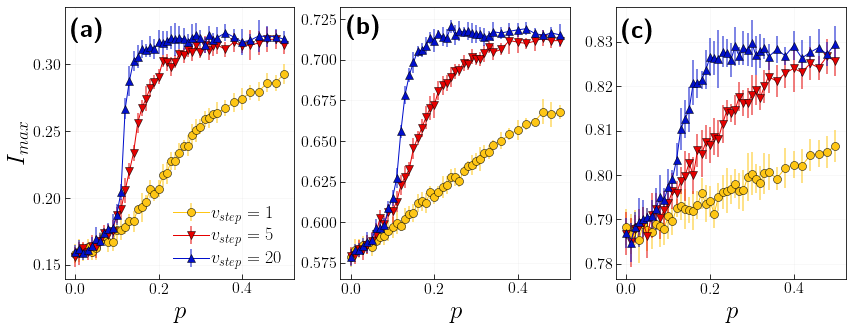

In [20]:
plot_p_vs_max_infected_all_betas(dfs)
# plt.savefig("../plots/paper/imax_vs_p_vsteps.pdf")
# plt.show()

In [9]:
# TODO: insert this figure to our publication, should we include errorbars or not???